## Compressed Sensing (Non-Uniform-Sampling) of MAT Experiment using Iterative Soft Thresholding

### water around 50 um polystyrene beads, spinning at 10Hz

In [30]:
import sys
sys.path.append( "..\\.")
import pylab
import numpy
import scipy
from   scipy import fftpack
from   scipy.fftpack import fft, ifft, hilbert, fftshift, rfft 

import os
import nmrglue
import twoDplot_1
import ist

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter

%matplotlib inline

### Read in Experimental Data

In [31]:

f1=64
zerofill = 512
f2=512
pp=16
expt_no = "103"  
#Z:\Documents\ipython-notebooks\2016\bruker_data\eeh_20160324_1_4mmHXG_50umBeads

directory = os.path.join("..","bruker_data", "eeh_20160324_1_4mmHXG_50umbeads" )

print directory

file_rrr = os.path.join( directory, expt_no, "pdata", "1")

file_ser = os.path.join(directory,expt_no)
                         
cs_file  = os.path.join( directory,expt_no,"vdlist")
file1    = os.path.join( directory,expt_no,"pdata","1","2rr" )



max_num_peaks = 10
tolerance = 25
iterations = 500

..\bruker_data\eeh_20160324_1_4mmHXG_50umbeads


In [32]:
pinfo,expt = nmrglue.bruker.read_pdata( file_rrr )
info,expt_fid = nmrglue.bruker.read( file_ser )

shape (32, 512.0)


In [33]:
## transfer fid into matrix with dimensions of final FFT spectra

(rr,cc) = expt.shape
expt = numpy.zeros((rr,cc),dtype=numpy.complex128)

(rr,cc) = expt_fid.shape
for r in range(rr):
    for c in range(cc):
        expt[r][c] = expt_fid[r][c]
        
del expt_fid

In [34]:
## read in compressed sensing positions 

cs_array = scipy.fromfile( cs_file, sep = " " )
cs_array = scipy.array( cs_array, dtype=numpy.int32 )

numpts = zerofill
mask = numpy.zeros(numpts, dtype=numpy.float32)

for i in cs_array[:pp]:
    mask[i] = 1.0


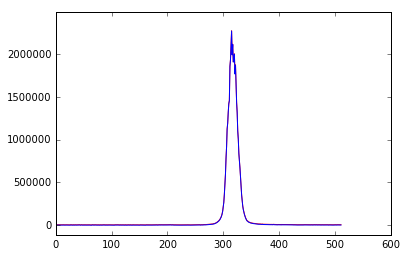

In [35]:
# Fourier Transform in F2 dimension

spec = fftpack.fft(expt, axis=1)
spec = fftpack.fftshift(spec, axes=1)


# Phase correct data and remove Bruker digitization artefacts

spec = nmrglue.process.proc_base.ps(spec, p0=-pinfo['procs']['PHC0']+6.0, p1=info['acqus']['GRPDLY']*360.0-pinfo['procs']['PHC1'], inv=False)


#Apply a simple base line correction to spectra in F2 dimension

(f1a,f2a) = expt.shape
pylab.plot(spec[0].real, 'r-');

for i in range(f1a):
    spec[i] = spec[i] - (spec[i][:100]).mean()
    
for i in range(f1a):
    spec[i] = spec[i] - (spec[i][:100]).mean()
    

pylab.plot(spec[0].real, 'b');
pylab.ylim(-0.05*spec[0].max(), 1.1*spec[0].max());

In [36]:
#  Split real and imaginary

iii_cs = spec[1::2].real
rrr_cs = spec[::2].real

In [37]:
# Create real and imag data arrays and put fids in correct position and order

rrr =scipy.zeros((zerofill,f2), dtype=numpy.int32)
iii =scipy.zeros((zerofill,f2), dtype=numpy.int32)


for i,v in enumerate(cs_array):
    rrr[v] = rrr[v]+rrr_cs[i]
    iii[v] = iii[v]+iii_cs[i]

In [38]:
# find the maximum index value in the first spectrum. Value used in he thresh-holding algorihm

mp =rrr[0].argmax()
rrr = rrr.transpose()
iii = iii.transpose()

mmm_t = (rrr + 1j*iii)

### Perform Iterative Soft Thesholding Procedure in T$_1$ dimension

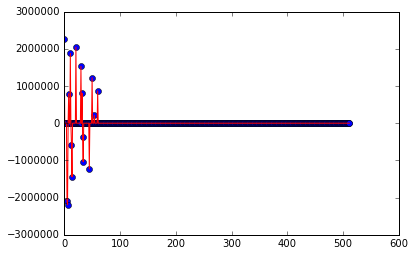

In [39]:
pylab.plot( mask*mmm_t[mp].real, 'o' );
pylab.plot( mmm_t[mp].real, 'r-' );

In [40]:
# Perform thresholding in T1 for each point

cs_spec = scipy.zeros((f2,zerofill), dtype=numpy.complex128)

stats_array = []

for j in range(f2):
    print j,

#    Y, stats = compressed_sensing_1VD( mmm_t[j], mask, num_iter=iterations, tol=tolerance, maxPeaks=max_num_peaks  )       
#    Y, stats = ist.compressed_sensing_1VD1b( mmm_t[j], mask,  maxPeaks=max_num_peaks  )
    Y, stats = ist.compressed_sensing_1VD1d( mmm_t[j], mask, num_iter=1000, maxPeaks=1000, peak_separation=1000, tolerance=5e-3 )
    cs_spec[j] = (Y + 1j * fftpack.hilbert( Y ))
    
    stats_array.append(stats)
    
#print stats_array

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

### Display Results

In [41]:
for m in range(f2):
    cs_spec[m] = fftpack.fftshift(cs_spec[m])

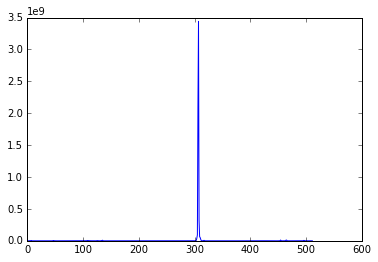

In [42]:
# Display high resolution projection 

cs_spec_sum1 = (cs_spec.real).sum(axis=1) 
#print cs_spec_sum1.max(), (cs_spec_sum[:]).sum()
ssum0 = (cs_spec.real).sum(axis=0)

pylab.plot( (cs_spec.real).sum(axis=0) );


In [43]:
spec = fftpack.fft(mmm_t, axis=1)

In [44]:
cs_spec_real = (cs_spec.real/10000.0)

In [45]:
cs_spec_int32 = scipy.array(cs_spec_real, dtype=scipy.int32)

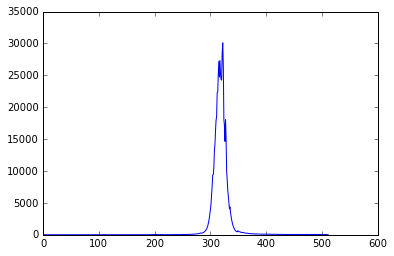

In [46]:
pylab.plot(((cs_spec_int32).sum(axis=1)));

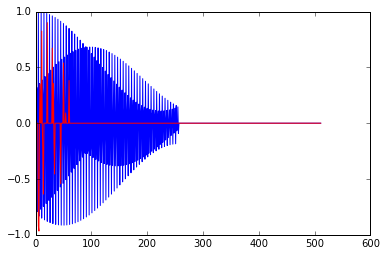

In [47]:
pylab.plot( fftpack.ifft(cs_spec[mp]).real/(fftpack.ifft(cs_spec[mp]).real).max() );
pylab.plot( mmm_t[mp].real/(mmm_t[mp].real).max(), 'r-' );

In [48]:
# Arrange 2-D spectrum  in correct order for display with Bruker Topsin

cs_spec_int32 = cs_spec_int32.transpose()
cs_spec_int32 = numpy.fliplr(cs_spec_int32)
cs_spec_int32 = numpy.flipud(cs_spec_int32)

In [49]:
cs_spec_int32 = cs_spec_int32.flatten()

In [50]:
#Store 2-D real spectum in Bruker daa directory
print file1
fp = open( file1, 'wb' )
cs_spec_int32.tofile(fp)
fp.close()

..\bruker_data\eeh_20160324_1_4mmHXG_50umbeads\103\pdata\1\2rr


In [51]:
stats_array = numpy.array(stats_array)

In [52]:
stats_array = stats_array.transpose()

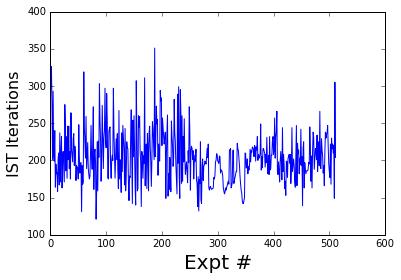

In [53]:
#final iteration value
pylab.plot( stats_array[0] ); 
pylab.xlabel("Expt #", fontsize =20);
pylab.ylabel("IST Iterations", fontsize=16);

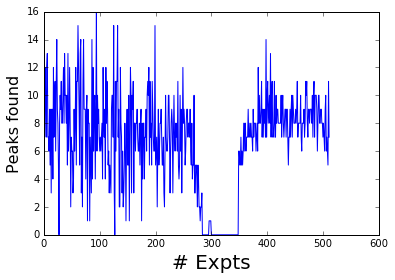

In [54]:
# final peaks found
pylab.plot( stats_array[1] ); 
pylab.xlabel("# Expts", fontsize =20);
pylab.ylabel("Peaks found", fontsize=16);

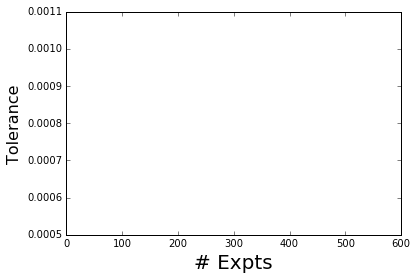

In [55]:
# final tolerance
pylab.plot( stats_array[2] ); 
pylab.xlabel("# Expts", fontsize =20);
pylab.ylabel("Tolerance", fontsize=16);
pylab.ylim(0.0005,0.0011);

In [56]:
#file_rrr = r'Z:\Documents\work\projects\CompressedSensing\Data\eeh_20140228_diffMAT_4mmHXG\224\pdata\1'
#info,expt = nmrglue.bruker.read_pdata( file_rrr )

expt = cs_spec_real

expt = np.flipud(expt)
expt = np.fliplr(expt)
expt = expt.transpose()

4.99787669632
[]


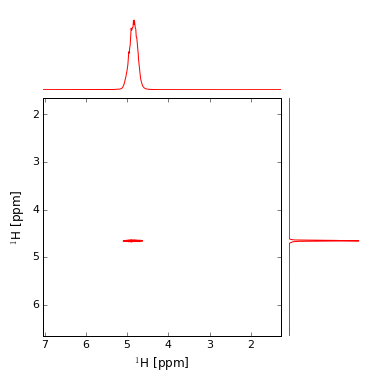

In [57]:
ppplot = twoDplot_1.TwoD_NMR_MAT_plot( expt, pinfo, info,contourlevels_range=[0.05,1.1])
ppplot.display_plot()

4.99787669632
[4.4, 4.9, 6, 3]


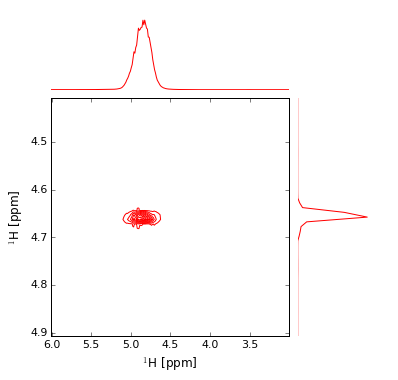

In [58]:
ppplot = twoDplot_1.TwoD_NMR_MAT_plot( expt, pinfo, info, dimensions_ppm=[4.4,4.9,6,3],contourlevels_range=[0.05,1.1])
ppplot.display_plot()